In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, datetime, timedelta
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import random
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from scipy.stats import norm
from sklearn.preprocessing import Normalizer,StandardScaler, LabelEncoder
from tensorflow_addons.losses import pinball_loss
from sklearn.metrics import mean_pinball_loss
from scipy import stats
import math

In [2]:
quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]
horizons = [36, 48 ,60, 72, 84]

# Read and preprocess data

In [3]:
#Wind data
wind_data = pd.read_feather("data/berlin_data/historic_data/icon_eps_wind_10m.feather")
#Pressure data
pressure_data = pd.read_feather("data/berlin_data/historic_data/icon_eps_mslp.feather")
pressure_data.rename({"ens_mean":"mean_pressure"}, axis = 1, inplace = True)
#Cloud data
cloud_data = pd.read_feather("data/berlin_data/historic_data/icon_eps_clct.feather")
cloud_data.rename({"ens_mean":"cloud_coverage"}, axis = 1, inplace = True)
#Vmax data
max_data = pd.read_feather("data/berlin_data/historic_data/icon_eps_vmax_10m.feather")
max_data.rename({"ens_mean":"vmax"}, axis = 1, inplace = True)


data = wind_data.merge(pressure_data[["init_tm","fcst_hour","mean_pressure"]], on = ["init_tm","fcst_hour"], how = "left")
data = data.merge(cloud_data[["init_tm","fcst_hour","cloud_coverage"]], on = ["init_tm","fcst_hour"], how = "left")
data = data.merge(max_data[["init_tm","fcst_hour","vmax"]], on = ["init_tm","fcst_hour"], how = "left")
#Replace vmax NaNs by mean
vmax_mean = data["vmax"].mean()
data.loc[:,"vmax"].fillna(vmax_mean, inplace = True)
data.dropna(inplace=True)
data.head()

,init_tm,met_var,location,fcst_hour,obs_tm,obs,ens_1,ens_2,ens_3,ens_4,...,ens_36,ens_37,ens_38,ens_39,ens_40,ens_mean,ens_var,mean_pressure,cloud_coverage,vmax
65,2018-12-19 00:00:00+00:00,wind_10m,Berlin,0.0,2018-12-19 00:00:00+00:00,12.60,9.69,9.60,9.85,9.80,...,10.53,11.33,9.40,9.62,9.97,9.71750,1.179127,1022.41475,3.26025,23.36562
66,2018-12-19 00:00:00+00:00,wind_10m,Berlin,1.0,2018-12-19 01:00:00+00:00,12.60,10.97,10.49,10.26,10.12,...,11.43,11.85,10.08,10.76,9.39,10.29675,1.028694,1021.70900,0.58050,23.36562
67,2018-12-19 00:00:00+00:00,wind_10m,Berlin,2.0,2018-12-19 02:00:00+00:00,12.24,11.76,11.47,10.54,10.51,...,11.90,12.27,10.36,11.58,9.67,10.99725,0.896077,1020.92025,0.96325,23.36562
68,2018-12-19 00:00:00+00:00,wind_10m,Berlin,3.0,2018-12-19 03:00:00+00:00,11.52,12.16,12.04,10.95,11.47,...,12.23,12.78,10.41,11.60,10.23,11.40975,0.622141,1020.62650,12.33875,23.36562
69,2018-12-19 00:00:00+00:00,wind_10m,Berlin,4.0,2018-12-19 04:00:00+00:00,10.08,12.57,12.79,11.21,12.36,...,12.91,13.52,11.14,12.16,11.34,12.02400,0.558978,1020.63250,32.37400,23.36562


## Create positional encoding

In [4]:
pos_enc = pd.DataFrame(index=pd.DatetimeIndex(data["obs_tm"]))
pos_enc["Dayofyear"] = pos_enc.index.dayofyear
pos_enc["n_days"] = 365
pos_enc.loc[pos_enc.index.year==2020,"n_days"] = 366
#Calculate actual positional encoding
cos_encoding = np.cos(2*math.pi*pos_enc["Dayofyear"]/pos_enc["n_days"])
data["pos_enc_1"] = cos_encoding.to_numpy()

## Train, val, test split

In [5]:
train_val_dataframe, test_dataframe = train_test_split(data, test_size = 0.2)#, random_state = 1)
train_dataframe, val_dataframe = train_test_split(data, test_size = 0.2)#, random_state = 2)

### Normalize

In [6]:
def normalize(dataframe, label_encoder = None,feature_scaler = None, target_scaler = None, learn = False):
    #Drop unused columns
    data = dataframe.copy()
    data.drop(["init_tm", "met_var", "location",  "ens_var", "obs_tm"], axis = 1, inplace = True)
    data = data.to_numpy()
    if learn == True:
        label_encoder = LabelEncoder()
        feature_scaler = StandardScaler()
        target_scaler = StandardScaler()
        #Learn label encoding for horizons
        label = label_encoder.fit_transform(data[:,0])
        #Learn target scaling
        target_scaled = target_scaler.fit_transform(data[:,1].reshape(-1,1))
        #Learn feature scaling
        feature_scaled = feature_scaler.fit_transform(data[:,2:])
        #Append
        data[:,0] = label
        data[:,1] = target_scaled.reshape(-1)
        data[:,2:] = feature_scaled
        
        return data, label_encoder, feature_scaler, target_scaler
    
    else:
        #Learn labels
        label = label_encoder.transform(data[:,0])
        #Scale target
        target_scaled = target_scaler.transform(data[:,1].reshape(-1,1))
        #Scale features
        feature_scaled = feature_scaler.transform(data[:,2:])
        #Append
        data[:,0] = label
        data[:,1] = target_scaled.reshape(-1)
        data[:,2:] = feature_scaled
        
        return data

In [7]:
train_val, label_encoder, feature_scaler, target_scaler = normalize(train_val_dataframe, learn = True)
train= normalize(train_dataframe, label_encoder, feature_scaler, target_scaler)
test = normalize(test_dataframe, label_encoder, feature_scaler, target_scaler)
val = normalize(val_dataframe, label_encoder, feature_scaler, target_scaler)
#Number of encodings
n_encodings = len(np.unique(train[:,0]))

In [8]:
def convert_format(input_data, predict = False):
    #Extract forecast embedding
    horizon_emb = input_data[:,0]
    
    if predict == False:        
        #Extract features
        features = input_data[:,2:]
        # Extract target
        target = np.expand_dims(input_data[:,1],1)
        return [features, horizon_emb], target
    else:
        #Extract features
        features = input_data[:,1:]
        return [features, horizon_emb]

In [9]:
train_data, train_target = convert_format(train)
val_data, val_target = convert_format(val)
test_data, test_target = convert_format(test)

# Create Model

In [10]:
class base_model(tf.keras.Model):    
    def __init__(self, n_embeddings = n_encodings):
        super(base_model, self).__init__()
        #Embedding layers
        self.embedding = Embedding(input_dim = n_embeddings, output_dim = 4)
        #Create Dense layers
        self.hidden = Dense(64, activation = "relu")
        self.hidden2 = Dense(32, activation = "relu")
        self.out = Dense(5, activation = "linear")

    def call(self, input_data):
        #Extract data
        features, horizon_emb = input_data
        #Calculate embedding
        emb = self.embedding(horizon_emb)
        emb = tf.squeeze(emb, axis = 1)
        conc = Concatenate(axis = 1)([features, emb])
        #Calculate output
        output = self.hidden(conc)
        output = self.hidden2(output)
        output = self.out(output)

        return output

In [11]:
#Define parameters
BATCH_SIZE = 512
EPOCHS = 100
learning_rate = 0.001

In [13]:
def train_model(train_data, train_target, validation_data, batch_size, epochs, learning_rate, fine_tuning = True):
    model = base_model()    
    #Define optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    #Callbacks
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 7, min_delta = 1e-5)
    model.compile(optimizer = optimizer, loss = lambda true,pred: pinball_loss(true, pred, tau = quantiles))
    #model.compile(optimizer = optimizer, loss = lambda true,pred: smooth_pinball_loss(true, pred, tau = quantiles))
    #Normal fit
    history1 = model.fit(x = train_data, y = train_target, validation_data = validation_data, epochs = epochs, batch_size = BATCH_SIZE, callbacks = [callback], shuffle = True, verbose = False)
    
    #Fine tuning
    if fine_tuning == True:
        enc_horizons = label_encoder.transform(horizons)
        train_filtering = np.isin(train_data[1], enc_horizons)
        train_data_fine = [train_data[0][train_filtering], train_data[1][train_filtering]]
        train_target_fine = train_target[train_filtering]
        #Val filtering
        val_data, val_target = validation_data
        val_filtering = np.isin(val_data[1], enc_horizons)
        val_data_fine = [val_data[0][val_filtering], val_data[1][val_filtering]]
        val_target_fine = val_target[val_filtering]
        validation_data_fine = (val_data_fine, val_target_fine)
        
        #New optimizer
        history2 = model.fit(x = train_data_fine, y = train_target_fine, validation_data = validation_data_fine, epochs = epochs, batch_size = 256, callbacks = [callback], shuffle = True, verbose = False)
    return model, [history1, history2]

# Predict test data

In [14]:
def aggregate_training(train_data, train_target, validation_data, test_data,  BATCH_SIZE, EPOCHS, learning_rate, n = 10):
    predictions = np.zeros(shape = (len(test_data[0]),5))
    for i in range(n):
        model,_ = train_model(train_data, train_target, validation_data, BATCH_SIZE, EPOCHS, learning_rate)
        pred = model.predict(test_data)
        predictions += pred
        print("Finished Training {}".format(i+1))
    predictions = predictions/n
    return predictions

In [15]:
predictions = aggregate_training(train_data, train_target, (val_data,val_target), test_data, BATCH_SIZE, EPOCHS, learning_rate)

Finished Training 1
Finished Training 2
Finished Training 3
Finished Training 4
Finished Training 5
Finished Training 6
Finished Training 7
Finished Training 8
Finished Training 9
Finished Training 10


## Pinball Loss

### All horizons

In [16]:
total_loss = 0
for cnt,quantile in enumerate(quantiles):
    loss = mean_pinball_loss(test_target.reshape(-1), predictions[:,cnt].reshape(-1), alpha = quantile)
    total_loss += loss
    print("Pinball loss for quantile {} : \t {}".format(quantile,loss))
print("Pinball Loss total: {}".format(total_loss/len(quantiles)))

Pinball loss for quantile 0.025 : 	 0.027956292595500924
Pinball loss for quantile 0.25 : 	 0.15608380617339532
Pinball loss for quantile 0.5 : 	 0.20197951334424172
Pinball loss for quantile 0.75 : 	 0.16953951144929016
Pinball loss for quantile 0.975 : 	 0.0357356368559843
Pinball Loss total: 0.11825895208368249


### Specific horizons

In [17]:
eval_df = test_dataframe[["fcst_hour","obs"]].copy()
eval_df["obs"] = target_scaler.transform(eval_df["obs"].to_numpy().reshape(-1,1))
for cnt,quantile in enumerate(quantiles):
    eval_df[quantile] = predictions[:,cnt]
eval_df = eval_df[eval_df["fcst_hour"].isin(horizons)]

total_loss = 0
for cnt,quantile in enumerate(quantiles):
    loss = mean_pinball_loss(eval_df["obs"], eval_df[quantile], alpha = quantile)
    total_loss += loss
    print("Pinball loss for quantile {} : \t {}".format(quantile,loss))
print("Pinball Loss total: {}".format(total_loss/len(quantiles)))

Pinball loss for quantile 0.025 : 	 0.029984333296388964
Pinball loss for quantile 0.25 : 	 0.15188991281768238
Pinball loss for quantile 0.5 : 	 0.1893372379973094
Pinball loss for quantile 0.75 : 	 0.15976834914660953
Pinball loss for quantile 0.975 : 	 0.033673360636888146
Pinball Loss total: 0.11293063877897569


## Plausability

### All horizons

In [18]:
for cnt,quantile in enumerate(quantiles):
    q_smaller = (predictions[:,cnt] > test_target.flatten()).sum()
    emp_quant = q_smaller / predictions[:,cnt].size
    print("Quantile met for quantile = {}: \t {} %".format(quantile, np.round(emp_quant,4)*100))

Quantile met for quantile = 0.025: 	 2.62 %
Quantile met for quantile = 0.25: 	 26.240000000000002 %
Quantile met for quantile = 0.5: 	 50.349999999999994 %
Quantile met for quantile = 0.75: 	 72.68 %
Quantile met for quantile = 0.975: 	 96.74000000000001 %


### Specific horizons

In [19]:
for quantile in quantiles:
    q_smaller = (eval_df[quantile] > eval_df["obs"]).sum()
    emp_quant = q_smaller / eval_df[quantile].size
    print("Quantile met for quantile = {}: \t {} %".format(quantile, np.round(emp_quant,4)*100))

Quantile met for quantile = 0.025: 	 2.64 %
Quantile met for quantile = 0.25: 	 22.97 %
Quantile met for quantile = 0.5: 	 50.3 %
Quantile met for quantile = 0.75: 	 75.1 %
Quantile met for quantile = 0.975: 	 97.76 %


## Visualize predictions

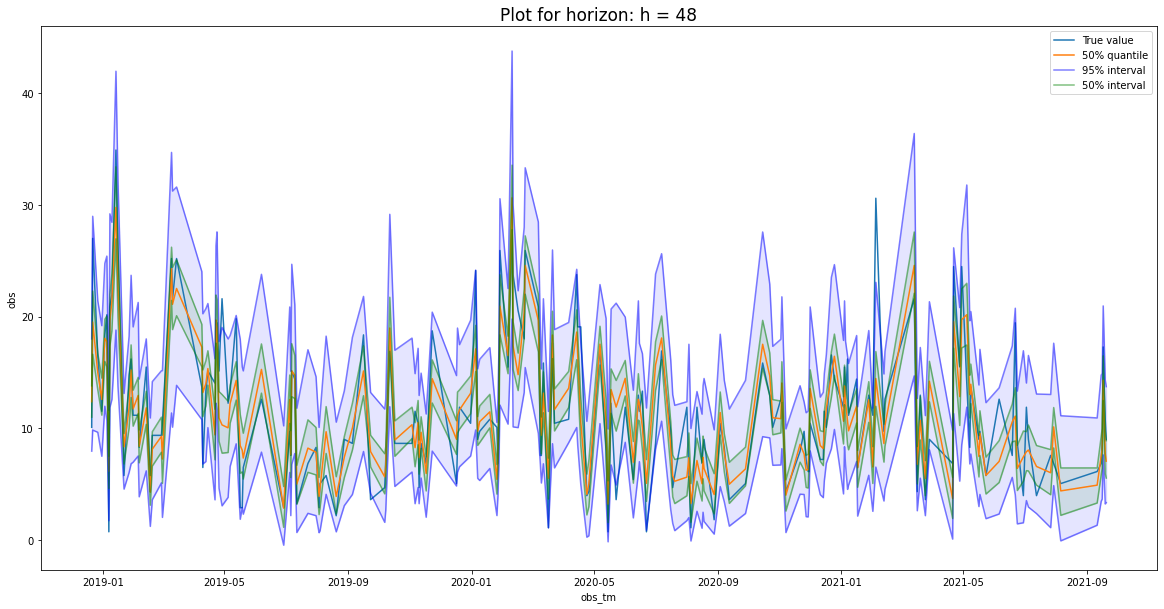

In [20]:
# Create plotting dataframe
data_plot = test_dataframe[["obs_tm","obs","fcst_hour"]].copy()
for cnt, quantile in enumerate(quantiles):
    data_plot["q{}".format(quantile)] = target_scaler.inverse_transform(predictions[:,cnt].reshape(-1,1)).reshape(-1)

#Extract horizon
h=48
data_plot = data_plot[data_plot["fcst_hour"]==h]
data_plot.sort_values(by = "obs_tm", inplace = True)

fig, axs = plt.subplots(figsize = (20,10))
sns.lineplot(x = "obs_tm", y = "obs", data = data_plot, label = "True value")
sns.lineplot(x = "obs_tm", y = "q0.5", data = data_plot, label = "50% quantile")
sns.lineplot(x = "obs_tm", y = "q0.025", data = data_plot, color = "blue", label = "95% interval", alpha = 0.5)
sns.lineplot(x = "obs_tm", y = "q0.975", data = data_plot, color = "blue", alpha = 0.5)
axs.fill_between(x = "obs_tm", y1 = "q0.025", y2 = "q0.975", data = data_plot, alpha = 0.1, color = "blue")

sns.lineplot(x = "obs_tm", y = "q0.25", data = data_plot, color = "green", label = "50% interval", alpha = 0.5)
sns.lineplot(x = "obs_tm", y = "q0.75", data = data_plot, color = "green", alpha = 0.5)
axs.fill_between(x = "obs_tm", y1 = "q0.25", y2 ="q0.75", data = data_plot, alpha = 0.1, color = "green")
axs.set_title("Plot for horizon: h = {}".format(h),size = 17)
axs.legend()

## Analyze crossing of quantiles

In [21]:
#Group prediction
perc_wrong_total = np.sum(np.diff(predictions) < 0) / len(predictions) * 100

#Single prediction
model,_ = train_model(train_data, train_target, (val_data, val_target), BATCH_SIZE, EPOCHS, learning_rate)
predictions_single = model.predict(test_data)
#Get amount of wrongly specified quantiles
perc_wrong_single = np.sum(np.diff(predictions_single) < 0) / len(predictions_single) * 100

print("Amount of wrongly specified quantiles in single prediction: {:.4f}%\nAmount of wrongly specified quantiles in aggregated prediction: {}%".format(perc_wrong_single, perc_wrong_total))

Amount of wrongly specified quantiles in single prediction: 0.2584%
Amount of wrongly specified quantiles in aggregated prediction: 0.0%


# Predict new data

## Train on complete data without test set

In [22]:
train_data, train_target = convert_format(train_val)
val_data, val_target = convert_format(test)

## Predict new data

In [23]:
current_date = date.today().strftime("%Y%m%d")
path = "data/berlin_data/icon_data/icon-eu-eps_{}00_wind_mean_10m_Berlin.txt".format(current_date)
new_data = pd.read_csv(path.format(current_date.replace("-","")), skiprows = 3, sep = "|").dropna(axis = 1)
new_data.columns = new_data.columns.str.replace(" ", "")
new_data["ens_mean"] = new_data.iloc[:,1:].mean(axis = 1)

#Add pressure data
pressure_pred = pd.read_csv("data/berlin_data/icon_data/icon-eu-eps_{}00_mslp_Berlin.txt".format(current_date.replace("-","")), skiprows = 3, sep = "|").dropna(axis = 1)
new_data["pressure_mean"] = pressure_pred.iloc[:,1:].mean(axis = 1)

#Add cloud data
cloud_pred = pd.read_csv("data/berlin_data/icon_data/icon-eu-eps_{}00_clct_Berlin.txt".format(current_date.replace("-","")), skiprows = 3, sep = "|").dropna(axis = 1)
new_data["cloud_coverage"] = cloud_pred.iloc[:,1:].mean(axis = 1)

#Add vmax data
max_pred = pd.read_csv("data/berlin_data/icon_data/icon-eu-eps_{}00_vmax_10m_Berlin.txt".format(current_date.replace("-","")), skiprows = 3, sep = "|").dropna(axis = 1)
new_data["vmax"] = max_pred.iloc[:,1:].mean(axis = 1)

#Filter horizons
new_data = new_data[new_data["fcst_hour"].isin(horizons)]

#Create positional encoding
date_list = [(date.today()+timedelta(x)) for x in horizons]
new_data["day"] = pd.DatetimeIndex(date_list).dayofyear
new_data["pos_enc_1"] = np.cos(2*math.pi*new_data["day"]/365)
new_data.drop("day", axis = 1, inplace = True)
# Normalize and get horizons
new_data = new_data[new_data["fcst_hour"].isin(horizons)].to_numpy()
new_data[:,1:] = feature_scaler.transform(new_data[:,1:])
new_data[:,0] = label_encoder.transform(new_data[:,0])

In [24]:
pred_data = convert_format(new_data, predict = True)

In [25]:
#Prepare dataframe
final_prediction = pd.DataFrame(columns = ["forecast_date","target","horizon","q0.025","q0.25","q0.5","q0.75","q0.975"], index = np.arange(0,5))
final_prediction["forecast_date"] = datetime.today().strftime("%Y-%m-%d")
final_prediction["horizon"] = ["{} hour".format(x) for x in horizons]
final_prediction["target"] = "wind"

In [26]:
# Predict data
predictions = aggregate_training(train_data, train_target, (val_data,val_target), pred_data, BATCH_SIZE, EPOCHS, learning_rate)

Finished Training 1
Finished Training 2
Finished Training 3
Finished Training 4
Finished Training 5
Finished Training 6
Finished Training 7
Finished Training 8
Finished Training 9
Finished Training 10


In [27]:
for cnt, quantile in enumerate(quantiles):
    #Retransform predictions
    final_pred = target_scaler.inverse_transform(predictions[:,cnt].reshape(-1,1))
    final_prediction.loc[:,"q{}".format(quantile)] = final_pred

In [28]:
final_prediction

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2021-12-22,wind,36 hour,5.713839,8.955569,10.165164,11.413184,14.934796
1,2021-12-22,wind,48 hour,7.499939,12.374469,14.403833,16.263296,21.117178
2,2021-12-22,wind,60 hour,7.926265,18.262470,21.743763,25.602411,37.443272
3,2021-12-22,wind,72 hour,3.957981,9.054567,11.247764,13.397608,19.609878
4,2021-12-22,wind,84 hour,5.665751,9.269823,10.899874,12.503932,18.329918


In [29]:
new_data = pd.read_csv(path.format(current_date.replace("-","")), skiprows = 3, sep = "|").dropna(axis = 1)
new_data.columns = new_data.columns.str.replace(" ", "")
new_data[new_data["fcst_hour"].isin(horizons)].quantile(0.5, axis = 1)

36     7.76
48     9.77
52    12.83
56     8.15
58     9.22
Name: 0.5, dtype: float64

In [30]:
final_prediction.to_pickle("../evaluation/predictions/single/{}_{}".format("wind", date.today().strftime("%Y-%m-%d")))

# Old code

## Check relationship with time

ValueError: Expected 2D array, got 1D array instead:
array=[-1.10319959 -0.60166495 -0.41452615 -0.22144236  0.32339325].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

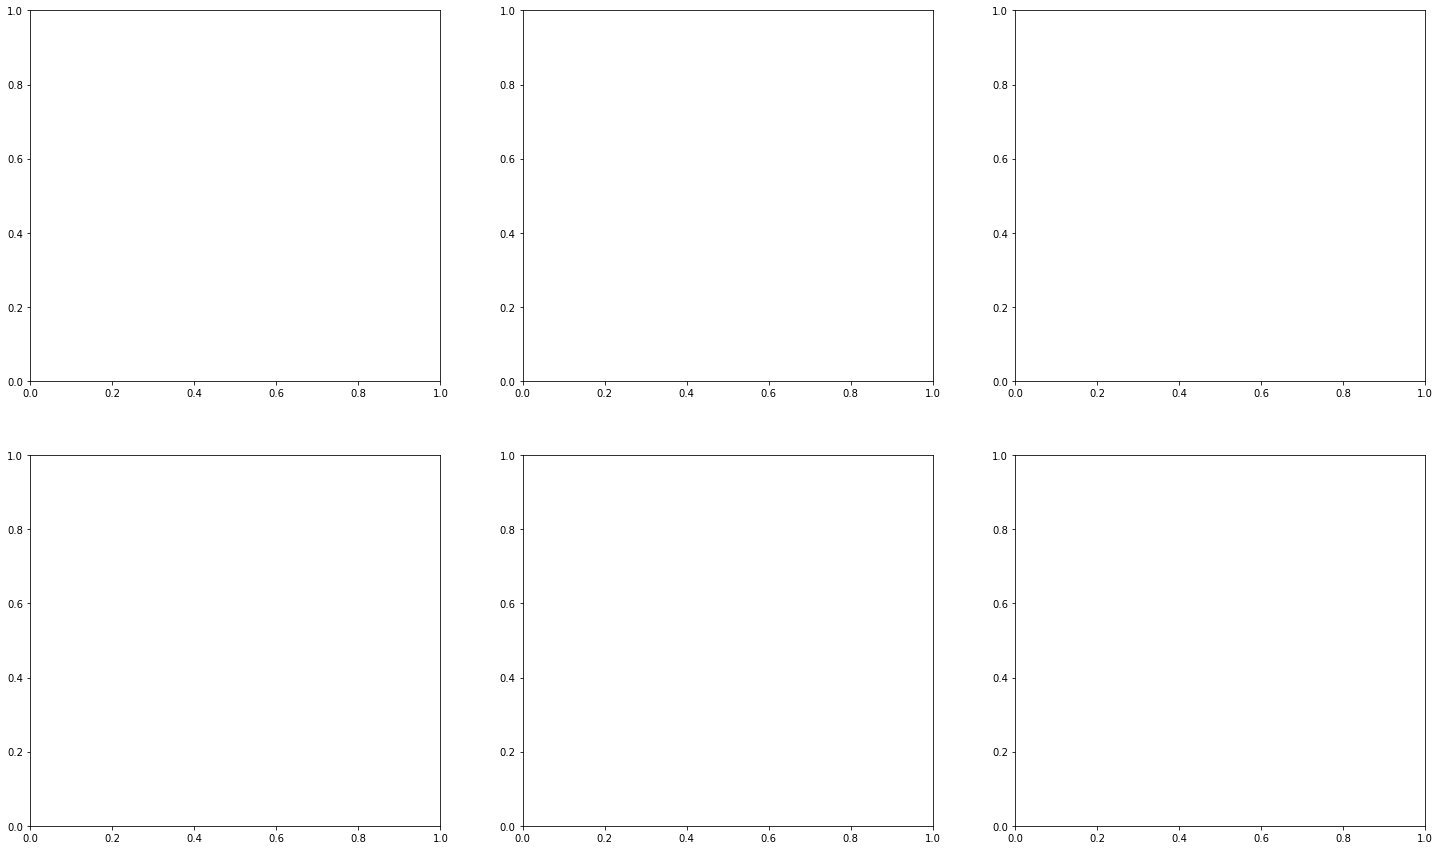

In [31]:
fig, ax = plt.subplots(2,3,figsize=(25,15))
ax = ax.ravel()
for cnt, quantile in enumerate(quantiles):
    #Renormalize and calculate forecast error
    error = mean_pinball_loss(test_dataframe["obs"].to_numpy().reshape(1,-1), target_scaler.inverse_transform(predictions[cnt]).reshape(1,-1), multioutput="raw_values", alpha=quantile)
    test_dataframe["Forecast_error"] = error
    test_dataframe["day"] = pd.DatetimeIndex(test_dataframe["obs_tm"]).dayofyear
    plot = test_dataframe.groupby("day").mean().reset_index()

    sns.regplot(x = "day", y = "Forecast_error", data=plot, ax = ax[cnt])
    ax[cnt].set_xlabel("Day of year",size = 15)
    ax[cnt].set_ylabel("Forecast error", size = 17)
    ax[cnt].set_title("Correlation for q = {}".format(quantile),size = 20)
    r = stats.pearsonr(plot["day"], plot["Forecast_error"])[0]
    rho = stats.spearmanr(plot["day"], plot["Forecast_error"])[0]
    ax[cnt].annotate('Correlation:\nr = {:.4f}\n'.format(r)+r'$\rho$ = {:.4f}'.format(rho),xy = (.01,.02), xycoords=ax[cnt].transAxes, size = 15)
    
#plt.savefig("wind_time_correlation_corrected_plot.pdf", dpi=300)